<a href="https://colab.research.google.com/github/rafayhabibullah/Qunat-Analysis/blob/master/BTC_SIP_with_multiple_strategies_and_price_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install yfinance pandas matplotlib numpy


=== FINAL SUMMARY ===
                                total_invested_usd  final_btc  last_price_usd  \
Basic_DCA_Trend_Upward                    3,652.00       0.11       98,401.48   
MA_Based_Trend_Upward                     4,442.00       0.14       98,401.48   
Dip_Buy_Trend_Upward                      3,822.00       0.11       98,401.48   
RSI_Adjusted_Trend_Upward                 3,833.00       0.11       98,401.48   
Hybrid_Trend_Upward                       5,846.00       0.18       98,401.48   
Basic_DCA_Cumulative_Growth               3,652.00       0.08      451,027.44   
MA_Based_Cumulative_Growth                3,647.00       0.13      451,027.44   
Dip_Buy_Cumulative_Growth                 3,822.00       0.09      451,027.44   
RSI_Adjusted_Cumulative_Growth            3,833.00       0.09      451,027.44   
Hybrid_Cumulative_Growth                  5,352.00       0.16      451,027.44   

                                portfolio_value_usd  \
Basic_DCA_Trend_Upward        

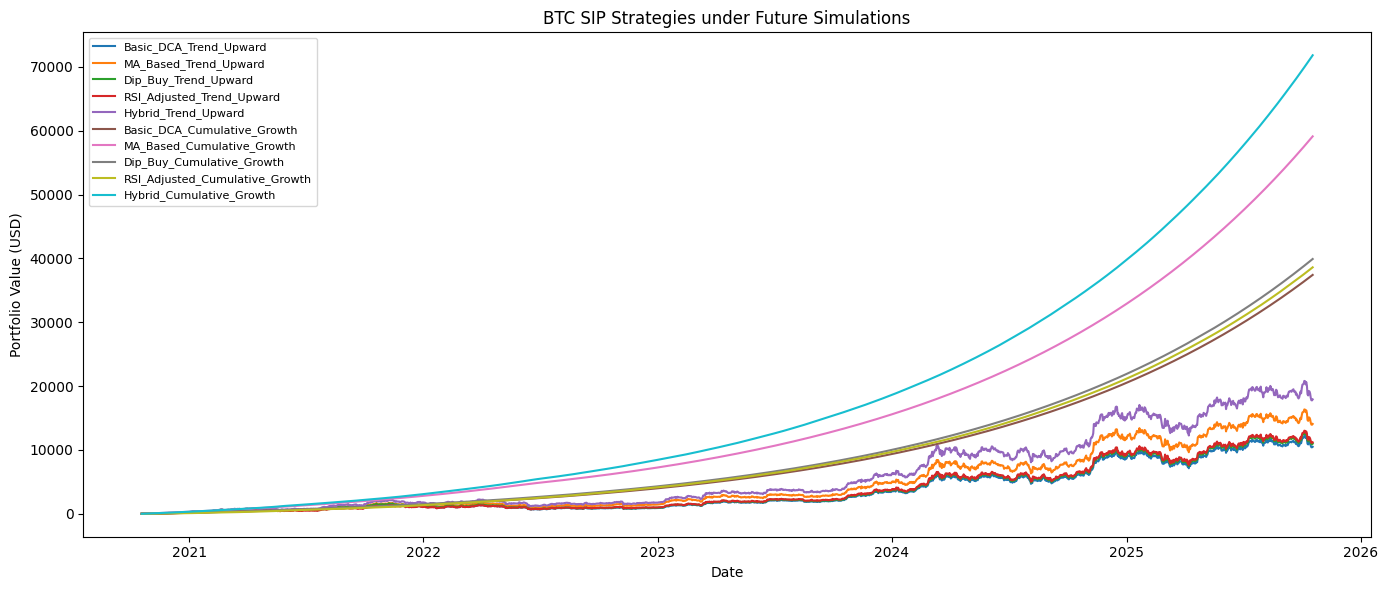

In [116]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

# -------------------------
# PARAMETERS
# -------------------------
base_daily_usd = 2.0
period_years = 5
end_date = datetime.now(timezone.utc).date()
start_date = end_date - timedelta(days=365 * period_years)
ticker = "BTC-USD"

save_csv = "btc_future_sim_summary.csv"
save_png = "btc_future_sim_chart.png"

# -------------------------
# HELPERS
# -------------------------
def to_float(x):
    if isinstance(x, pd.Series):
        return float(x.values[0]) if len(x) > 0 else np.nan
    elif isinstance(x, (np.ndarray, list)):
        return float(x[0]) if len(x) > 0 else np.nan
    try:
        return float(x)
    except:
        return np.nan

def rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ma_up = up.rolling(period, min_periods=1).mean()
    ma_down = down.rolling(period, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-12)
    return 100 - (100 / (1 + rs))

# -------------------------
# FETCH DATA
# -------------------------
df = yf.download(
    ticker,
    start=start_date.strftime("%Y-%m-%d"),
    end=(end_date + timedelta(days=1)).strftime("%Y-%m-%d"),
    progress=False,
    auto_adjust=False
)
df = df[["Close"]].rename(columns={"Close":"close"})
df.index = pd.to_datetime(df.index)  # keep DatetimeIndex
df = df.sort_index()

# -------------------------
# INDICATORS
# -------------------------
df["ma200"] = df["close"].rolling(200, min_periods=1).mean()
df["rsi14"] = rsi(df["close"], period=14)
df["daily_pct"] = df["close"].pct_change()*100

# -------------------------
# SIP STRATEGIES
# -------------------------
def buy_basic(date, row, df_all):
    # print("basic")
    return base_daily_usd

def buy_ma(date, row, df_all):
    # print("ma")
    close = to_float(row["close"])
    ma200 = to_float(row["ma200"])
    if np.isnan(ma200): ma200 = close
    return base_daily_usd * (2.0 if close < ma200 else 0.5)

def buy_dip(date, row, df_all):
    # print("dip")
    daily_pct = to_float(row["daily_pct"])
    return base_daily_usd*2.0 if daily_pct <= -5 else base_daily_usd

def buy_rsi(date, row, df_all):
    # print("rsi")
    rsi_val = to_float(row["rsi14"])
    if rsi_val<35: return base_daily_usd*2.0
    elif rsi_val>70: return base_daily_usd*0.5
    return to_float(base_daily_usd)

def buy_hybrid(date, row, df_all):
    # print("hybrid")
    close = to_float(row["close"])
    ma200 = to_float(row["ma200"])
    rsi_val = to_float(row["rsi14"])
    daily_pct = to_float(row["daily_pct"])

    if np.isnan(ma200): ma200=close
    if np.isnan(rsi_val): rsi_val=50
    if np.isnan(daily_pct): daily_pct=0

    usd = base_daily_usd
    add_mult = 0.0
    if close < ma200: add_mult += 1.0
    if rsi_val < 35: add_mult += 1.0
    if daily_pct <= -5: add_mult += 1.0
    usd *= (1 + add_mult)
    if rsi_val>70 and close>ma200:
        usd = base_daily_usd*0.5
    return usd

strategies = {
    "Basic_DCA": buy_basic,
    "MA_Based": buy_ma,
    "Dip_Buy": buy_dip,
    "RSI_Adjusted": buy_rsi,
    "Hybrid": buy_hybrid
}

# -------------------------
# SIMULATOR
# -------------------------
def simulate_strategy(df, buy_rule_fn):
    df2 = df.copy()
    df2["usd_invested"]=0.0
    df2["btc_bought"]=0.0

    for d,row in df2.iterrows():
        usd = to_float(buy_rule_fn(d,row,df2))
        price = to_float(row["close"])
        if np.isnan(price) or price<=0 or usd<=0:
            df2.at[d,"usd_invested"]=0.0
            df2.at[d,"btc_bought"]=0.0
            continue
        btc = usd/price
        df2.at[d,"usd_invested"]=usd
        df2.at[d,"btc_bought"]=btc

    df2["cum_usd"]=df2["usd_invested"].cumsum()
    df2["cum_btc"]=df2["btc_bought"].cumsum()

    last_price = to_float(df2["close"].iloc[-1])
    final_btc = to_float(df2["cum_btc"].iloc[-1])
    total_invested = to_float(df2["cum_usd"].iloc[-1])
    portfolio_value = final_btc*last_price
    avg_buy_price = total_invested/final_btc if final_btc>0 else np.nan
    roi_pct = (portfolio_value-total_invested)/total_invested*100 if total_invested>0 else np.nan

    stats = {
        "total_invested_usd": total_invested,
        "final_btc": final_btc,
        "last_price_usd": last_price,
        "portfolio_value_usd": portfolio_value,
        "avg_buy_price_usd_per_btc": avg_buy_price,
        "roi_pct": roi_pct,
        "days_invested": int((df2["usd_invested"]>0).sum())
    }
    return df2, stats

# -------------------------
# FUTURE SIMULATIONS
# -------------------------
def future_trend(df, lookback_days=30, noise_sigma=0.01):
    df_sim = df.copy()

    # Compute recent percent change safely
    pct_change_series = df_sim['close'].pct_change(periods=lookback_days)
    recent_pct_change = pct_change_series.iloc[-1]
    if isinstance(recent_pct_change, pd.Series):
        recent_pct_change = recent_pct_change.values[0] if len(recent_pct_change) > 0 else 0.0
    recent_pct_change = float(recent_pct_change) if not np.isnan(recent_pct_change) else 0.0

    # Generate noise
    noise = np.random.normal(0, noise_sigma, len(df_sim))

    # Multiply elementwise safely
    adjusted_close = df_sim['close'].to_numpy().flatten() * (1.0 + recent_pct_change) * (1.0 + noise)

    # Assign back safely
    df_sim['close'] = pd.Series(adjusted_close, index=df_sim.index)
    return df_sim


def future_cumulative_growth(df, daily_growth=0.002):
    df_sim = df.copy()
    n = len(df_sim)

    # ensure scalar starting price
    start_price = to_float(df_sim['close'].iloc[0])

    # 1D cumulative growth array
    cum_growth = np.cumprod(np.ones(n) * (1 + daily_growth))

    # multiply to get adjusted close
    adjusted_close = start_price * cum_growth

    # assign safely back to df
    df_sim['close'] = pd.Series(adjusted_close, index=df_sim.index)
    return df_sim

simulations = {
    "Trend_Upward": future_trend,
    "Cumulative_Growth": future_cumulative_growth
}

# -------------------------
# RUN STRATEGIES ON SIMULATIONS
# -------------------------
results = {}
frames = {}

for sim_name, sim_fn in simulations.items():
    df_sim = sim_fn(df)  # pass full DataFrame
    for strat_name, strat_fn in strategies.items():
        frame, stats = simulate_strategy(df_sim, strat_fn)
        key = f"{strat_name}_{sim_name}"
        results[key] = stats
        frames[key] = frame

# -------------------------
# FINAL SUMMARY
# -------------------------
summary = pd.DataFrame(results).T
summary = summary[[
    "total_invested_usd",
    "final_btc",
    "last_price_usd",
    "portfolio_value_usd",
    "avg_buy_price_usd_per_btc",
    "roi_pct",
    "days_invested"
]]
summary.to_csv(save_csv)
print("\n=== FINAL SUMMARY ===")
print(summary)

# -------------------------
# PLOT RESULTS
# -------------------------
plt.figure(figsize=(14,6))
for key, frame in frames.items():
    frame = frame.copy()
    cum_btc = frame["cum_btc"].to_numpy().flatten()   # ensure 1D
    close = frame["close"].to_numpy().flatten()       # ensure 1D
    frame["port_value"] = cum_btc * close
    frames[key] = frame

    # plot with label
    plt.plot(frame.index, frame["port_value"], label=key)

plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.title("BTC SIP Strategies under Future Simulations")
plt.legend(fontsize=8)  # now will correctly show labels
plt.tight_layout()
plt.savefig(save_png, dpi=150)
plt.show()
